# 通过Python的Networkx和Sklearn来介绍隐性马尔科夫模型

## 马尔科夫是何人？
### 马尔科夫是一位俄国的数学家，他最为人所知的是他在随机过程方面的研究。他早期研究的重点是数论而在1900年之后他所研究的重点转向了概率论。他研究的成果颇丰以至于在他1905年正式退休之后他仍然在教授课程直至去世。在他的研究中，马尔科夫成功地拓展了大数定理以及中心极限定理，并将其应用于由独立随机变量组成的特定序列中，如今这也被称为马尔可夫链。马尔可夫链被广泛的运用于物理学，经济学，统计学，生物学等方面。两个最著名的应用是布朗运动以及随机漫步。

## 什么是马尔科夫性质？
### 一类随机过程：在给定当前状态的条件下，将来的状态独立于过去的状态。
### 假定我们用一枚正反面概率一样的硬币玩一个简单的抛硬币的游戏。抛去质疑，假设马尔科夫性质不是已知的，并且我们希望去预测在十次抛掷以后，第11次正面朝上的概率。在条件依赖的假设之下（硬币对于过去的状态有记忆特性并且未来的状态也依赖于过去状态的序列）,我们必须记录导致第11次结果的前十次结果的特定序列，并计算它们的联合概率。这个序列的联合概率就是0.5^10 = 0.0009765625。在条件依赖下，第十一次抛掷正面朝上的概率就是0.0009765625 * 0.5 = 0.00048828125。
### 这真的是第十一次抛掷正面朝上的概率吗？当然不是！
### 我们知道硬币抛掷这一事件并不依赖于先前抛掷的结果。这枚硬币并没有记忆特性。这个连续抛掷的过程并没有编码先前的结果。每个抛掷都是独立事件并且是正反面概率一致的，又叫做与过去状态的条件独立。这就是马尔科夫性质。

## 什么是马尔科夫模型？
### 马尔科夫链（模型）描述了一类随机过程，假定未来状态的概率仅仅依赖于当前状态，不依赖于先前的状态。
### 让我们以一个简单的例子开始。假设你的小狗处于三类状态之一，在给定当前状态的条件下，你想要模拟出未来状态的可能性。为此我们需要去指定状态空间，初始概率和转移概率。
### 想象一下你有一只非常懒的胖狗，所以我们定义了状态空间为：睡觉，吃饭，赖皮。我们设置对应的初始概率为 35%, 35%,和 30% 。

In [72]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# create state space and initial state probabilities

states = ['sleeping', 'eating', 'pooping']
pi = [0.35, 0.35, 0.3]
state_space = pd.Series(pi, index=states, name='states')
print(state_space)
print(state_space.sum())

sleeping    0.35
eating      0.35
pooping     0.30
Name: states, dtype: float64
1.0


### 下一步就是定义转移概率。在给定当前状态的条件下，他们就是保持相同状态的概率或者转移到不同状态的概率。

In [73]:
# create transition matrix
# equals transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states
q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.4,0.2,0.4]
q_df.loc[states[1]] = [0.45, 0.45, 0.1]
q_df.loc[states[2]] = [0.45, 0.25, 0.3]

print(q_df)

q = q_df.values
print('\n',q, q.shape, '\n')
print(q_df.sum(axis=1))

         sleeping eating pooping
sleeping      0.4    0.2     0.4
eating       0.45   0.45     0.1
pooping      0.45   0.25     0.3

 [[0.4 0.2 0.4]
 [0.45 0.45 0.1]
 [0.45 0.25 0.3]] (3, 3) 

sleeping    1.0
eating      1.0
pooping     1.0
dtype: float64


### 既然我们有了初始概率和转移概率，我们就能用Networkx包来创建马尔科夫图表了。要做到这一点需要一点点灵活思考。Networkx创造了包含很多节点和边的图。
### 在我们这个小例子中，小狗可能的状态是这些节点，而边则是连接各个节点的连线。而转移概率则是权重。它们代表了在当前状态已知的情况下转移至下一状态的概率。
### 有一点需要指出的是networkx主要是用来处理字典对象的。也就是说，我们需要去创建一个包含边以及对应权重的字典对象。

In [74]:
from pprint import pprint

# create a function that maps transition probability dataframe
# to markov edges and weights

def _get_markov_edges(Q):
    edges={}
    for col in Q.columns:
        for idx in Q.index:
            print(idx,col)
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

sleeping sleeping
eating sleeping
pooping sleeping
sleeping eating
eating eating
pooping eating
sleeping pooping
eating pooping
pooping pooping
{('eating', 'eating'): 0.45,
 ('eating', 'pooping'): 0.1,
 ('eating', 'sleeping'): 0.45,
 ('pooping', 'eating'): 0.25,
 ('pooping', 'pooping'): 0.3,
 ('pooping', 'sleeping'): 0.45,
 ('sleeping', 'eating'): 0.2,
 ('sleeping', 'pooping'): 0.4,
 ('sleeping', 'sleeping'): 0.4}


### 现在我们能够创建这个图。为了能够使得马尔科夫模型可视化需要使用nx.MultiDiGraph。一个多有向图简单来说就是有方向的图表，能够拥有多条弧，同时单个节点既可以是起始点也可以是终点。在接下来的代码中，我们将创建图标对象，添加我们的节点，边和标签，接着画一个大致的netwokx图线，并且将其输出为dot文件。

Nodes:
['sleeping', 'eating', 'pooping']

Edges:
[('sleeping', 'sleeping', {'label': 0.4, 'weight': 0.4}),
 ('sleeping', 'eating', {'label': 0.2, 'weight': 0.2}),
 ('sleeping', 'pooping', {'label': 0.4, 'weight': 0.4}),
 ('eating', 'sleeping', {'label': 0.45, 'weight': 0.45}),
 ('eating', 'eating', {'label': 0.45, 'weight': 0.45}),
 ('eating', 'pooping', {'label': 0.1, 'weight': 0.1}),
 ('pooping', 'sleeping', {'label': 0.45, 'weight': 0.45}),
 ('pooping', 'eating', {'label': 0.25, 'weight': 0.25}),
 ('pooping', 'pooping', {'label': 0.3, 'weight': 0.3})]


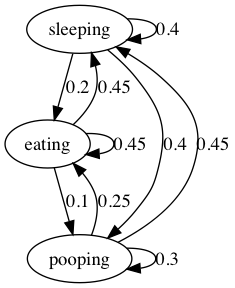

/Users/liling/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


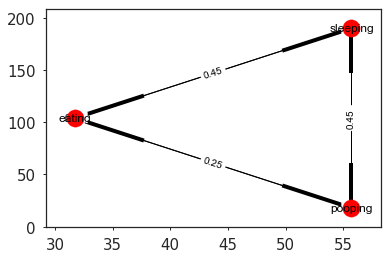

In [75]:
import pygraphviz as pgv
from subprocess import check_call
from IPython.display import Image

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov.dot')

check_call(['dot','-Tpng','pet_dog_markov.dot','-o','pet_dog_markov.png'])

Image(filename='pet_dog_markov.png') 

### 如果你想从任意节点开始沿着某一条边，他会告诉你这条小狗从一个状态转化为另一个状态的概率。举个例子来说吧，如果这条狗正在睡觉，我们能够发现有40%几率这条狗会继续睡觉，40%的几率狗会醒来并且耍赖皮，还有20%的概率狗会醒过来吃饭。
## 什么使得马尔科夫模型成为隐性的？
### 假设这样一种情况：你的狗突然举止怪异，你想要去模拟出狗是由于生病而有怪异行为的概率或者是在健康状态下纯粹地搞怪的概率。
### 在这一情形下，狗的真正状态是未知的，并且你也是不知晓的。一条可行的方法就是假设狗有一些可被观察的行为，这些行为能够代表正确而隐性的状态。让我们通过一个例子来了解。
### 首先我们创建状态空间，健康或生病。我们假设它们是等概的。

In [76]:
# create state space and initial state probabilities

hidden_states = ['healthy', 'sick']
pi = [0.5, 0.5]
state_space = pd.Series(pi, index = hidden_states, name='states')
print(state_space)
print('\n', state_space.sum())

healthy    0.5
sick       0.5
Name: states, dtype: float64

 1.0


### 现在我们为隐藏状态创建转移矩阵。

In [77]:
# create hidden transition matrix
# a or alpha
# = transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7,0.3]
a_df.loc[hidden_states[1]] = [0.4,0.6]

print(a_df)

a = a_df.values
print('\n', a, a.shape, '\n')
print(a_df.sum(axis=1))

        healthy sick
healthy     0.7  0.3
sick        0.4  0.6

 [[0.7 0.3]
 [0.4 0.6]] (2, 2) 

healthy    1.0
sick       1.0
dtype: float64


### 这就让它变得更有趣一点了。现在我们创建发射或者观察概率矩阵。这个矩阵的大小是M x O 的，并且M是隐藏状态的个数，而O则是可能观察到的状态的个数。这个发射矩阵告诉我们，在可能当前以及可观察的状态条件下，狗处于其中一个隐藏状态的概率。让我们保留前一个例子中的可观察状态。这条狗能够睡觉，吃饭或者耍赖皮。这样我们就能根据这些概率做出最准确的猜测。

In [78]:
# create matrix of observation (emission) probabilities
# b or beta = observation probabilities given state
# matrix is size (M x O) where M is number of states
# and O is number of different possible observations

observable_states = states

b_df = pd.DataFrame(columns = observable_states, index = hidden_states)
b_df.loc[hidden_states[0]] = [0.2,0.6,0.2]
b_df.loc[hidden_states[1]] = [0.4,0.1,0.5]

print(b_df)

b = b_df.values
print('\n', b, b.shape, '\n')
print(b_df.sum(axis=1))

        sleeping eating pooping
healthy      0.2    0.6     0.2
sick         0.4    0.1     0.5

 [[0.2 0.6 0.2]
 [0.4 0.1 0.5]] (2, 3) 

healthy    1.0
sick       1.0
dtype: float64


###  现在我们创建图的边和图对象

In [79]:
# create graph edges and weights
hide_edges_wts = _get_markov_edges(a_df)
pprint(hide_edges_wts)

emit_edges_wts = _get_markov_edges(b_df)
pprint(emit_edges_wts)

healthy healthy
sick healthy
healthy sick
sick sick
{('healthy', 'healthy'): 0.7,
 ('healthy', 'sick'): 0.3,
 ('sick', 'healthy'): 0.4,
 ('sick', 'sick'): 0.6}
healthy sleeping
sick sleeping
healthy eating
sick eating
healthy pooping
sick pooping
{('healthy', 'eating'): 0.6,
 ('healthy', 'pooping'): 0.2,
 ('healthy', 'sleeping'): 0.2,
 ('sick', 'eating'): 0.1,
 ('sick', 'pooping'): 0.5,
 ('sick', 'sleeping'): 0.4}


Nodes:
['healthy', 'sick']

Edges:
[('healthy', 'healthy', {'label': 0.7, 'weight': 0.7}),
 ('healthy', 'sick', {'label': 0.3, 'weight': 0.3}),
 ('healthy', 'sleeping', {'label': 0.2, 'weight': 0.2}),
 ('healthy', 'eating', {'label': 0.6, 'weight': 0.6}),
 ('healthy', 'pooping', {'label': 0.2, 'weight': 0.2}),
 ('sick', 'healthy', {'label': 0.4, 'weight': 0.4}),
 ('sick', 'sick', {'label': 0.6, 'weight': 0.6}),
 ('sick', 'sleeping', {'label': 0.4, 'weight': 0.4}),
 ('sick', 'eating', {'label': 0.1, 'weight': 0.1}),
 ('sick', 'pooping', {'label': 0.5, 'weight': 0.5})]


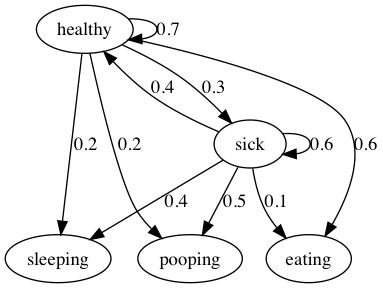

/Users/liling/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


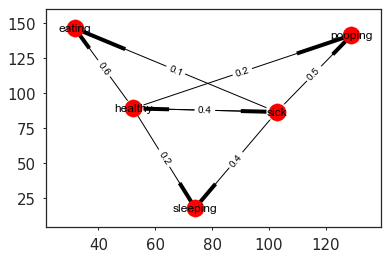

In [80]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(hidden_states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent hidden probabilities
for k,v in hide_edges_wts.items():
    tmp_orign, tmp_destination = k[0],k[1]
    G.add_edge(tmp_orign, tmp_destination, weight=v, label=v)
    
# edges represent emission probabilities
for k,v in emit_edges_wts.items():
    tmp_orign, tmp_destination = k[0],k[1]
    G.add_edge(tmp_orign, tmp_destination, weight=v, label=v) 
    
print(f'Edges:')
pprint(G.edges(data=True))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=emit_edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_hidden_markov.dot')
check_call(['dot','-Tpng','pet_dog_hidden_markov.dot','-o','pet_dog_hidden_markov.png'])
Image(filename='pet_dog_hidden_markov.png') 

### 这个隐性的马尔科夫的图表有一些复杂但其原理是一样。举个例子来说，你能够预测到，如果你的小狗在吃饭，那它有极高的可能是健康的（60%），而有非常低的可能是生病的（10%）。现在，给定一组你的小狗的行为序列，如果你需要识别出小狗随着时间变化的健康状态又该怎么办呢？

In [81]:
# observation sequence of dog's behaviors
# observations are encoded numerically

obs_map = {'sleeping':0, 'eating':1, 'pooping':2}
obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])

inv_obs_map = dict((v,k) for k,v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print(pd.DataFrame(np.column_stack([obs,obs_seq]),
                  columns=['Obs_code','Obs_seq']))

   Obs_code   Obs_seq
0         1    eating
1         1    eating
2         2   pooping
3         1    eating
4         0  sleeping
5         1    eating
6         2   pooping
7         1    eating
8         0  sleeping
9         2   pooping
10        2   pooping
11        0  sleeping
12        1    eating
13        0  sleeping
14        1    eating


### 使用维特比算法我们可以在给定行为序列的条件下，求出其最可能的对应的隐藏状态的序列。高水平下，这个维特比算法增量随着每个时间的步进，找到所有路径中能够以最大可能性到达时间t下的状态i的路径，这条路径也是到达时间t的正确观察行为序列。这个算法也能够保存在每一个阶段下有最高概率的状态的踪迹。在序列的结尾，这一算法将会向后迭代计算出在每一个时间步长中“胜利”的状态，并建立最有可能的路径，或者最有可能的隐藏状态的序列，这些都与已知的行为序列相对应。

In [82]:
# define Viterbi algorithm for shortest path
# code adapted from Stephen Marsland's, Machine Learning An Algorthmic
# Perspective, Vol. 2
# https://github.com/alexsosn/MarslandMLAlgo/blob/master/Ch16/HMM.py
def Viterbi(pi,a,b,obs):
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    
    path = np.zeros(T)
    delta = np.zeros((nStates,T))
    phi = np.zeros((nStates,T))
    
    delta[:,0] = pi * b[:,obs[0]]
    phi[:,0] = 0
    
    print('\nStart Walk Forward\n')
    for t in range(1,T):
        for s in range(nStates):
            delta[s,t] = np.max(delta[:,t-1]*a[:,s])*b[s,obs[t]]
            phi[s,t] = np.argmax(delta[:,t-1]*a[:,s])
            print('s={s} and t={t}: phi[{s},{t}] = {phi}'.format(s=s,t=t,phi=phi[s,t]))
    
    print('-'*50)
    print('Start Backtrace\n')
    path[T-1] = np.argmax(delta[:,T-1])
    for t in range(T-2,-1,-1):
        path[t] = phi[path[t+1],t+1]
        print('path[{}] = {}'.format(t,path[t]))

    return path,delta, phi

path, delta, phi = Viterbi(pi, a, b, obs)
print('\nsingle best stat path: \n', path)
print('delta:\n',delta)
print('phi:\n', phi)


Start Walk Forward

s=0 and t=1: phi[0,1] = 0.0
s=1 and t=1: phi[1,1] = 0.0
s=0 and t=2: phi[0,2] = 0.0
s=1 and t=2: phi[1,2] = 0.0
s=0 and t=3: phi[0,3] = 0.0
s=1 and t=3: phi[1,3] = 1.0
s=0 and t=4: phi[0,4] = 0.0
s=1 and t=4: phi[1,4] = 0.0
s=0 and t=5: phi[0,5] = 0.0
s=1 and t=5: phi[1,5] = 1.0
s=0 and t=6: phi[0,6] = 0.0
s=1 and t=6: phi[1,6] = 0.0
s=0 and t=7: phi[0,7] = 0.0
s=1 and t=7: phi[1,7] = 1.0
s=0 and t=8: phi[0,8] = 0.0
s=1 and t=8: phi[1,8] = 0.0
s=0 and t=9: phi[0,9] = 0.0
s=1 and t=9: phi[1,9] = 1.0
s=0 and t=10: phi[0,10] = 1.0
s=1 and t=10: phi[1,10] = 1.0
s=0 and t=11: phi[0,11] = 1.0
s=1 and t=11: phi[1,11] = 1.0
s=0 and t=12: phi[0,12] = 1.0
s=1 and t=12: phi[1,12] = 1.0
s=0 and t=13: phi[0,13] = 0.0
s=1 and t=13: phi[1,13] = 0.0
s=0 and t=14: phi[0,14] = 0.0
s=1 and t=14: phi[1,14] = 1.0
--------------------------------------------------
Start Backtrace

path[13] = 0.0
path[12] = 0.0
path[11] = 1.0
path[10] = 1.0
path[9] = 1.0
path[8] = 1.0
path[7] = 0.0
path[

/Users/liling/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### 让我们看一下结果吧

In [83]:
state_map = {0:'health',1:'sick'}
state_path = [state_map[v] for v in path]

(pd.DataFrame().assign(Observation=obs_seq).assign(Best_Path=state_path))

,Observation,Best_Path
0,eating,health
1,eating,health
2,pooping,health
3,eating,health
4,sleeping,health
5,eating,health
6,pooping,health
7,eating,health
8,sleeping,sick
9,pooping,sick


## 一种可用于条件检测的隐性马尔科夫模型
### 到现在，你可能想知道我们怎么样去将我们所学的马尔科夫模型应用在定量金融中。当考虑到当我们想要尝试在资产收益率中应用预测技术时，所面临最大的困难就是资产收益率是非平稳时间序列。简单来说，这就是意味着资产收益率的预期均值以及波动性都会随着时间而变化。大多数时间序列的模型都是假设数据是平稳的。这就是这些模型主要的缺陷。但是，让我们从问题的另外一面思考。我们知道这个时间序列其实表明了当前的时间点下预期均值以及波动性是固定不变的。而这些时间点或者说是条件就可以比喻为隐性状态。如果是这样的话，我们就只需要得到这些拥有与隐性状态对应特征的观察变量就可以了。如果我们能够更好地预估出资产所处在的最可能的环境，包括它的联合均值和方差，那么我们的预测模型就能变得更加灵活，并且能够提高准确度。当然如果给定的这些条件预估参数能够组成更有利于情景分析的框架，我们也能够成为更优秀的风险管理人员。

### 在这个例子中，我使用的观测变量有：潜在的资产回报，泰德价差，10年- 2年连续成熟的范围，和10年-3个月的连续成熟的范围。

            TEDRATE  T10Y2Y  T10Y3M        SPY      sret
2002-01-03     0.18    1.97    3.43  87.009605  0.011275
2002-01-04     0.18    1.99    3.46  87.590468  0.006654
2002-01-07     0.22    2.01    3.41  86.972374 -0.007082
2002-01-08     0.19    2.03    3.42  86.771304 -0.002315
2002-01-09     0.19    2.07    3.42  86.063851 -0.008186


/Users/liling/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


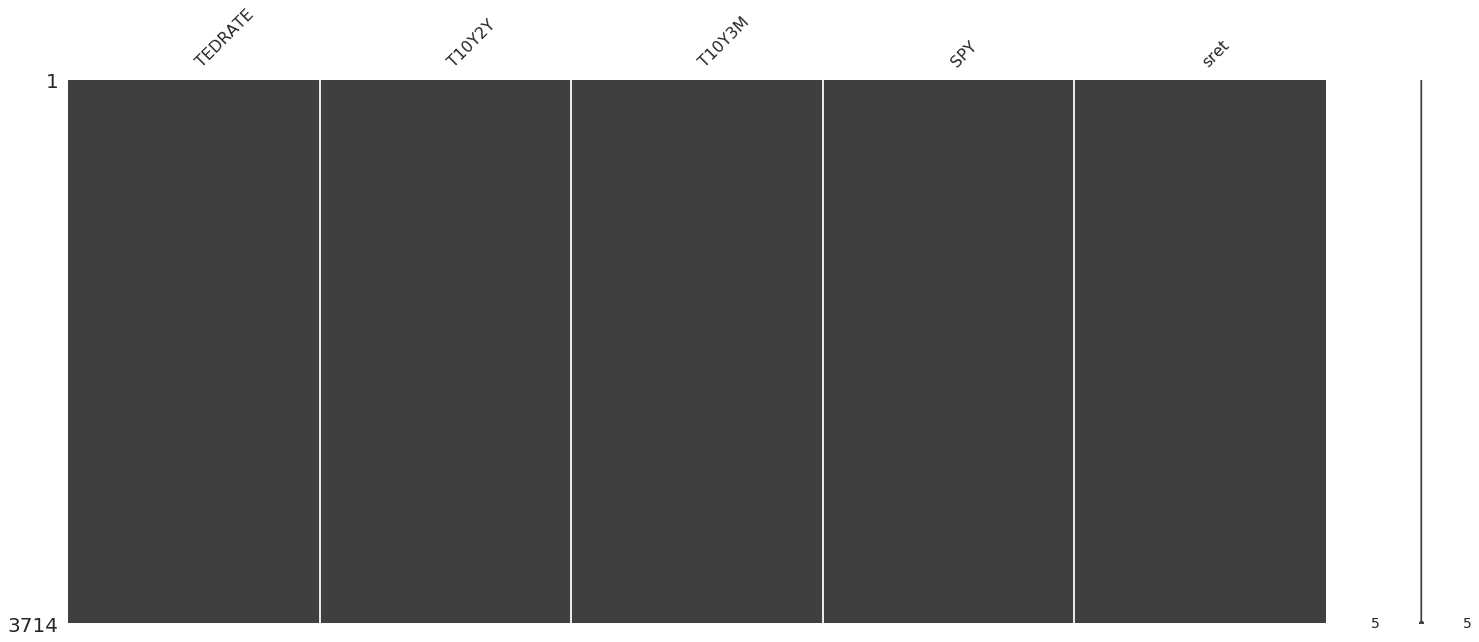

In [84]:
import pandas as pd
import pandas_datareader.data as web
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm

p = print

# get fed data

f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

mkt = 'SPY'
MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
       .rename(columns={mkt:mkt})
       .assign(sret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
       .dropna())

data = (web.DataReader([f1, f2, f3], 'fred', start, end)
        .join(MKT, how='inner')
        .dropna()
       )

p(data.head())

# gives us a quick visual inspection of the data
msno.matrix(data)

### 下面我们将会用到sklearn的高斯混合模型来组成一个能够预测这些条件的模型。混合模型应用一种密度估算中无人监测的形式来进行实现。它利用最大化均值算法来估算隐性状态的的均值和协方差。现在，就可以按下这个按钮，来猜猜转移和发射概率以及最可能的路径。我们必须选定混合模型中组件的数量来和时间序列相拟合。在这个例子中这些组件就被当作隐性状态。我们将这些状态任意划分为高，中和低波动性并且将组件部分设置为3。

Means and vars of each hidden state
0th hidden state
mean =  [  1.12631660e+00   1.58785233e+00   2.08179647e+00  -1.09199905e-03]
var =  [  5.23256292e-01   3.39472417e-01   7.79013756e-01   4.87312665e-04]

1th hidden state
mean =  [ 0.47860931  0.04304907  0.0977586   0.00067294]
var =  [  1.15442435e-02   1.86786935e-02   1.90710720e-01   4.08195183e-05]

2th hidden state
mean =  [  2.56533545e-01   1.89037844e+00   2.48159768e+00   4.46655073e-04]
var =  [  8.77053904e-03   3.41936313e-01   4.85216293e-01   8.23787573e-05]



/Users/liling/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


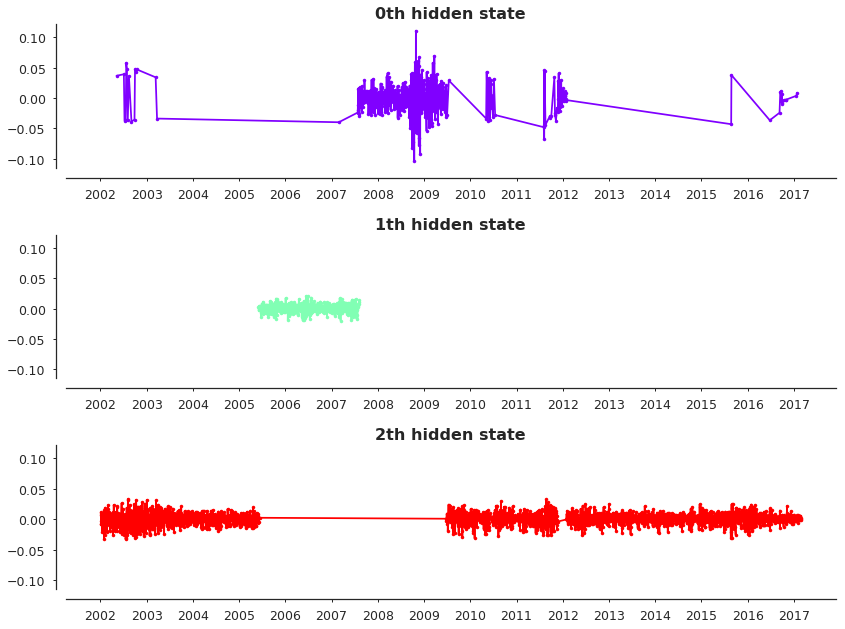

In [85]:
# code adapted from http://hmmlearn.readthedocs.io
# for sklearn 18.1

col = 'sret'
select = data.ix[:].dropna()

ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

### 在上面的图片中，每个条件下所对应的每日收入的预期均值和方差是每一种隐态的最后一列。我们的低波动性环境就是我们序号为1的隐态。我们也能发现序号为1的隐态下有最高额的收入均值和最小的方差。而序号为2的隐态即为中性的波动性环境，对应的是第二高的回报和方差。最后的序号为0的隐性状态即为高的波动性环境，对应的是负的回报以及最大的方差。

        Date  states  TEDRATE  T10Y2Y  T10Y3M        SPY      sret  mkt_cret
0 2002-01-03       2     0.18    1.97    3.43  87.009605  0.011275  0.011275
1 2002-01-04       2     0.18    1.99    3.46  87.590468  0.006654  0.017929
2 2002-01-07       2     0.22    2.01    3.41  86.972374 -0.007082  0.010847
3 2002-01-08       2     0.19    2.03    3.42  86.771304 -0.002315  0.008533
4 2002-01-09       2     0.19    2.07    3.42  86.063851 -0.008186  0.000346


/Users/liling/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


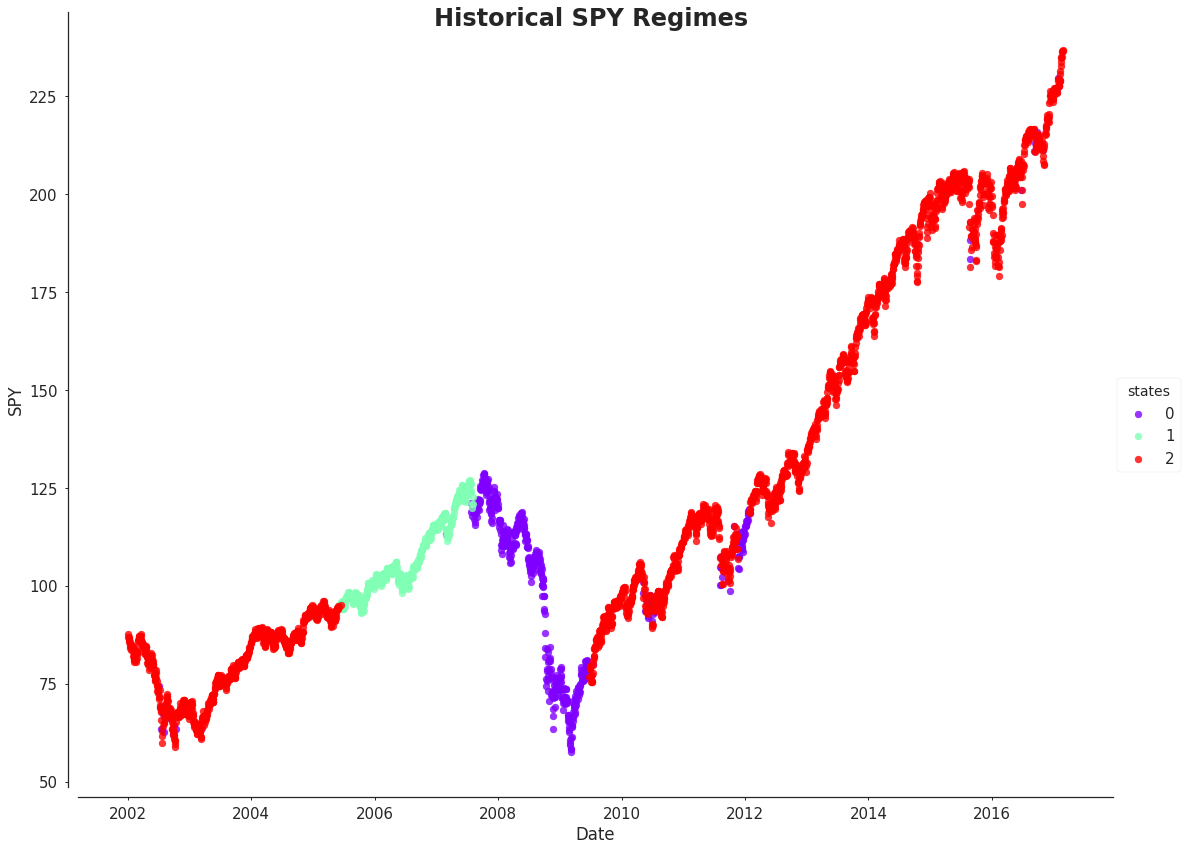

In [86]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPY Regimes', fontsize=24, fontweight='demi')
fg.savefig('Hidden Markov (Mixture) Model_SPY Regimes.png')

## 总结：
### 这篇文章中我们讨论了马尔科夫性质的概念，马尔可夫模型和隐性的马尔可夫模型。我们使用NetworkX包创建马尔科夫链图，并用sklearn的高斯混合模型预测以往各个节点的状态。为了了解更详细的信息，我建议你多看看参考文献中的内容。特别是Setosa.io这个网站由于其有极好的交互式的视觉体验，有助于你更好地理解这篇文章。
1.     https://en.wikipedia.org/wiki/Andrey_Markov

2.     https://www.britannica.com/biography/Andrey-Andreyevich-Markov

3.     https://www.reddit.com/r/explainlikeimfive/comments/vbxfk/eli5_brownian_motion_and_what_it_has_to_do_with/

4.     http://www.math.uah.edu/stat/markov/Introduction.html

5.     http://setosa.io/ev/markov-chains/

6.     http://www.cs.jhu.edu/~langmea/resources/lecture_notes/hidden_markov_models.pdf

7.     https://github.com/alexsosn/MarslandMLAlgo/blob/master/Ch16/HMM.py

8.     http://hmmlearn.readthedocs.io